In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub



In [13]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')


In [14]:
tf.saved_model.save(model,'./saved')


In [15]:
!cp -r /content/saved/ /content/drive/MyDrive/Models

In [68]:
content_image = plt.imread('/content/pyramid.jpg')

style_image = plt.imread('/content/ABT.jpg')


In [69]:
model1 = tf.saved_model.load('/content/')

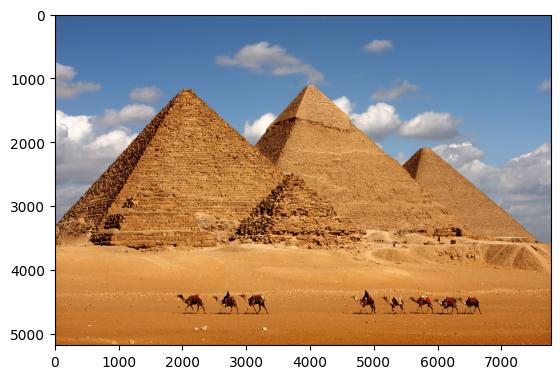

In [70]:
plt.imshow(content_image)


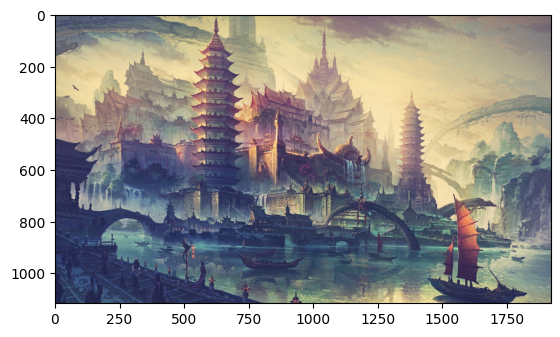

In [71]:
plt.imshow(style_image)


In [72]:
print('Content image size:', content_image.shape)
print('Style image size:', style_image.shape)


Content image size: (5184, 7776, 3)
Style image size: (1116, 1920, 3)


In [73]:
# Change the dimensions to your desired size
desired_size = (1024, 1024)

content_image = tf.image.resize(content_image, desired_size)
style_image = tf.image.resize(style_image, desired_size)


In [74]:
print('Content image size:', content_image.shape)
print('Style image size:', style_image.shape)


Content image size: (1024, 1024, 3)
Style image size: (1024, 1024, 3)


In [75]:
content_image = tf.cast(content_image, tf.float32)[tf.newaxis, ...] / 255.
style_image = tf.cast(style_image, tf.float32)[tf.newaxis, ...] / 255.


In [76]:
# content_image = tf.image.rgb_to_yuv(content_image)
# style_image = tf.image.rgb_to_yuv(style_image)

In [77]:
# # Apply Gaussian blurring
# content_image = tf.nn.avg_pool(content_image, ksize=[3,3], strides=[1,1], padding='SAME')
# style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

In [78]:

# # Mean Subtraction
# mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
# content_image = content_image - mean
# style_image = style_image - mean

In [79]:
# Apply style transfer
outputs = model1(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]


In [80]:
stylized_image

<tf.Tensor: shape=(1, 1024, 1024, 3), dtype=float32, numpy=
array([[[[0.38507816, 0.3549094 , 0.49075884],
         [0.36710578, 0.32915324, 0.4674186 ],
         [0.38583073, 0.34671262, 0.4883968 ],
         ...,
         [0.58253086, 0.59678614, 0.6956329 ],
         [0.6143485 , 0.62534165, 0.725025  ],
         [0.6231    , 0.61576307, 0.71105236]],

        [[0.39997536, 0.37217328, 0.49395698],
         [0.38383898, 0.34686938, 0.47261   ],
         [0.40152022, 0.3600438 , 0.49116084],
         ...,
         [0.5880562 , 0.59253514, 0.67849034],
         [0.60129577, 0.61434776, 0.6994807 ],
         [0.60899943, 0.6004918 , 0.68098074]],

        [[0.36754212, 0.34980786, 0.45387438],
         [0.35827643, 0.33361265, 0.44088697],
         [0.3833223 , 0.3496957 , 0.46596798],
         ...,
         [0.57536006, 0.59032255, 0.64694613],
         [0.5702324 , 0.5916366 , 0.65506744],
         [0.5903487 , 0.59832764, 0.64902586]],

        ...,

        [[0.5392823 , 0.42474297

In [81]:
#Define the loss functions
# def compute_content_loss(base_content, target):
#     return tf.reduce_mean(tf.abs(base_content - target))
def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))
# def gram_matrix(input_tensor):
#     result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
#     input_shape = tf.shape(input_tensor)
#     num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
#     return result/(num_locations)
def gram_matrix(input_tensor):

  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)






def compute_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))





In [82]:
print(tf.rank(style_image))
print(tf.rank(stylized_image))


tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [83]:
print(tf.rank(style_image))
print(tf.rank(stylized_image))


tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [84]:
print(tf.shape(style_image))
print(tf.shape(stylized_image))


tf.Tensor([   1 1024 1024    3], shape=(4,), dtype=int32)
tf.Tensor([   1 1024 1024    3], shape=(4,), dtype=int32)


In [85]:
# style_image = tf.expand_dims(style_image, axis=0)
# stylized_image = tf.expand_dims(stylized_image, axis=0)


In [86]:
style_image = tf.squeeze(style_image, axis=0)
stylized_image = tf.squeeze(stylized_image, axis=0)


In [87]:
# Compute the content and style losses
content_loss = compute_content_loss(content_image, stylized_image)
style_image = tf.expand_dims(style_image, axis=0)
stylized_image = tf.expand_dims(stylized_image, axis=0)

style_loss = compute_style_loss(gram_matrix(style_image), gram_matrix(stylized_image))

print('Content Loss:', content_loss.numpy())
print('Style Loss:', style_loss.numpy())


Content Loss: 0.039692495
Style Loss: 0.046426877


In [88]:
# Define the weights
content_weight = 1e3
style_weight = 1e-2


In [89]:
# Compute the weighted losses
loss = content_weight * content_loss + style_weight * style_loss

In [90]:
print(' Weighted Loss:', loss.numpy())
# print('Style Loss:', style_loss.numpy())

 Weighted Loss: 39.69296


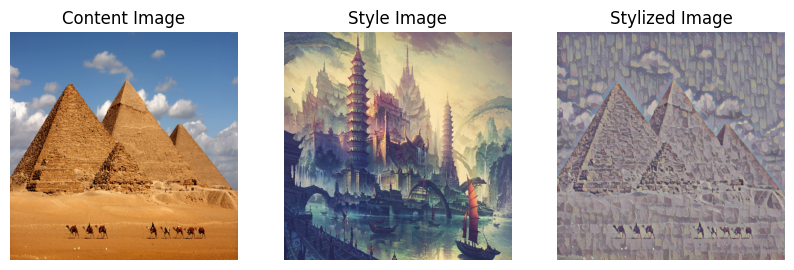

In [91]:
# Display the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(content_image[0])
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_image[0])
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(stylized_image[0])
plt.title('Stylized Image')
plt.axis('off')

plt.show()


In [92]:


# Assume 'stylized_image' is your generated image
stylized_image = tf.image.adjust_contrast(stylized_image, 2)  # Increase contrast by a factor of 2
stylized_image = tf.image.adjust_saturation(stylized_image, 2)  # Increase saturation by a factor of 2


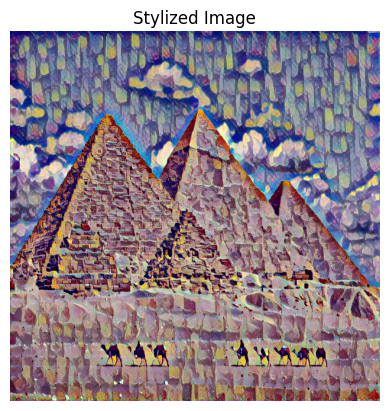

In [93]:
plt.imshow(stylized_image[0])
plt.title('Stylized Image')
plt.axis('off')

plt.show()